# Flower Recognition Using Deep Learning
### Project Overview
The objective of this deep learning project is to develop a model that can accurately classify images of flowers from a diverse dataset. Utilizing advanced image recognition algorithms within convolutional neural networks (CNNs), this endeavor aims to discern among various flower species, enhancing our understanding and interaction with natural flora through technological means.
### Approach
Our approach involves the use of two distinct Residual Network (ResNet) architectures: ResNet9 and ResNet50. These models are chosen for their demonstrated success in image classification tasks, with ResNet9 providing a streamlined alternative to the more complex ResNet50.

#### *ResNet9:* A concise, custom-built model with 9 layers, designed for rapid computation without sacrificing the ability to extract relevant features for classification tasks.
#### *ResNet50:* A deeper, pre-trained network consisting of 50 layers, known for its prowess in identifying intricate patterns in large and varied datasets like ImageNet.

### Dataset
The dataset comprises 4242 labeled images of flowers categorized into five classes: chamomile, tulip, rose, sunflower, and dandelion. Each class is represented by approximately 800 images, sourced from platforms such as Flickr, Google Images, and Yandex Images. The images vary in resolution, with an average size of about 320x240 pixels, and they maintain their original proportions, adding to the challenge of the classification task.

### Methodology
The project is structured around several key phases:
#### Data Preprocessing:
Standardizing the images through resizing, augmentation, and normalization to prepare them for the training process.
Model Training: The ResNet models are trained on the preprocessed dataset, with ResNet50 benefiting from transfer learning due to its pre-trained ImageNet weights.
#### Performance Evaluation:
We assess the models using metrics such as accuracy, precision, recall, and f1-score on a separate validation set to gauge their classification efficacy.
#### Comparative Analysis:
A thorough comparison of ResNet9 and ResNet50 is conducted to identify the most effective model for our dataset and determine the optimal balance between computational efficiency and predictive performance.


### Install and Import Libraries

In [ ]:
# Install opendatasets library for downloading datasets from online sources
!pip install opendatasets --upgrade --quiet

# Import necessary libraries
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import opendatasets as od

### Download and Prepare Dataset
Enter Username and Key from Kaggle

In [ ]:
# Part 2: Download and Prepare Dataset
dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'
data_dir = './flowers-recognition/flowers'

# Check if the dataset directory exists already, if so, remove it
if os.path.exists('./flowers-recognition'):
    shutil.rmtree('./flowers-recognition')

# Download the dataset from Kaggle
od.download(dataset_url)

# Remove unnecessary nested directory if exists
if os.path.exists(data_dir + '/flowers'):
    shutil.rmtree(data_dir + '/flowers')


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shravanikarra
Your Kaggle Key: ··········


100%|██████████| 225M/225M [00:13<00:00, 17.9MB/s]


### Data Transformations and Augmentation

In [ ]:
# Define transformations for the training data with augmentation
train_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.RandomCrop(64),
    transforms.RandomHorizontalFlip(),  # Data Augmentation: Horizontal Flip
    transforms.RandomRotation(10),       # Data Augmentation: Rotation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define transformations for the validation data without augmentation
valid_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


### Load and Explore Dataset

In [ ]:
# Applying transformations and loading the dataset
dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

# Splitting the dataset into training and validation datasets
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_ds, valid_ds = random_split(dataset, [train_size, val_size])

# Apply validation transforms to the validation dataset
valid_ds.dataset.transform = valid_transforms

# Printing basic information about the dataset
print("Total images in dataset:", len(dataset))
print("Classes in dataset:", dataset.classes)



Total images in dataset: 4317
Classes in dataset: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


### Create Data Loaders

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


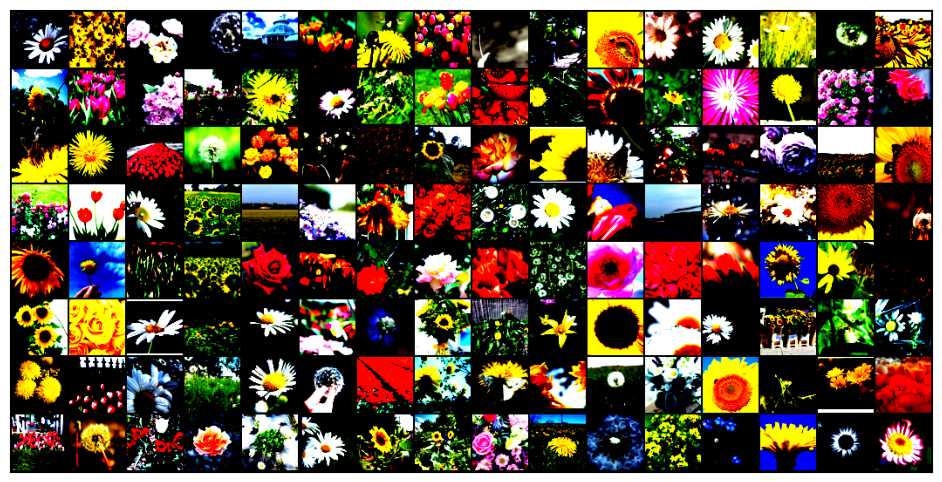

In [ ]:
batch_size = 128

# Creating data loaders for training and validation datasets
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=4, pin_memory=True)

def show_batch(dl):
    """Function to show a batch of images"""
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

# Display a batch of images
show_batch(train_dl)


### Define GPU Utilities

In [ ]:

def get_default_device():
    """Return the default device for computation."""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to the chosen device."""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a DataLoader to move data to a device."""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# Setting Up the Device for Training
device = get_default_device()
print("Using device:", device)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


Using device: cuda


### Define Model and Training Utilities

In [ ]:

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


### Define Model Architecture for ResNet9 with Dimension Correction

In [ ]:
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = self.create_conv_block(in_channels, 64)   # first conv block
        self.conv2 = self.create_conv_block(64, 128, pool=True) # second conv block with pooling
        self.res1 = nn.Sequential(self.create_conv_block(128, 128),
                                  self.create_conv_block(128, 128)) # first residual block

        self.conv3 = self.create_conv_block(128, 256, pool=True) # third conv block with pooling
        self.conv4 = self.create_conv_block(256, 512, pool=True) # fourth conv block with pooling
        self.res2 = nn.Sequential(self.create_conv_block(512, 512),
                                  self.create_conv_block(512, 512)) # second residual block

        self.classifier = nn.Sequential(
            nn.AdaptiveMaxPool2d(1),  # Adaptive pooling
            nn.Flatten(),             # Flatten the output
            nn.Dropout(0.2),          # Dropout for regularization
            nn.Linear(512, num_classes) # Fully connected layer
        )

    def create_conv_block(self, in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                  nn.BatchNorm2d(out_channels),
                  nn.ReLU(inplace=True)]
        if pool:
            layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

# Instantiate the model and move it to the appropriate device
model = to_device(ResNet9(3, len(dataset.classes)), device)


### Enhanced Training with Improvements and Visualization for ResNet9

Epoch [0], train_loss: 1.2822, val_loss: 0.9644, val_acc: 0.6147
Epoch [1], train_loss: 0.8518, val_loss: 0.7952, val_acc: 0.7116
Epoch [2], train_loss: 0.7291, val_loss: 0.7354, val_acc: 0.7238
Epoch [3], train_loss: 0.6380, val_loss: 0.7030, val_acc: 0.7322
Epoch [4], train_loss: 0.5470, val_loss: 0.6869, val_acc: 0.7607
Epoch [5], train_loss: 0.4192, val_loss: 0.5637, val_acc: 0.7822
Epoch [6], train_loss: 0.3570, val_loss: 0.5415, val_acc: 0.7794
Epoch [7], train_loss: 0.3431, val_loss: 0.5152, val_acc: 0.8221
Epoch [8], train_loss: 0.3048, val_loss: 0.5457, val_acc: 0.7813
Epoch [9], train_loss: 0.2920, val_loss: 0.5253, val_acc: 0.8196
Epoch [10], train_loss: 0.2620, val_loss: 0.5434, val_acc: 0.8042
Epoch [11], train_loss: 0.2571, val_loss: 0.5390, val_acc: 0.7998
Epoch [12], train_loss: 0.2578, val_loss: 0.5315, val_acc: 0.8076
Early stopping triggered after epoch 12


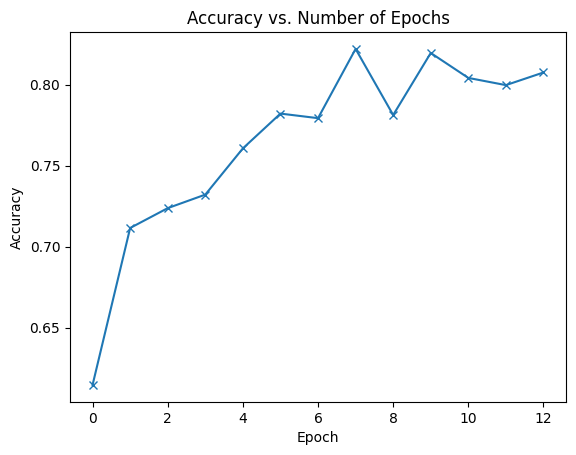

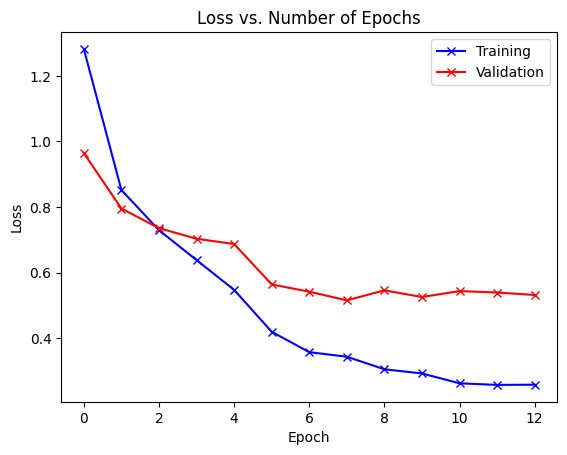

In [ ]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.0005
patience = 5  # Patience for early stopping

def fit_with_early_stopping(epochs, lr, model, train_loader, val_loader, opt_func, patience):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Learning rate scheduler
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

        # Early stopping logic
        val_loss = result['val_loss']
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print('Early stopping triggered after epoch', epoch)
            break

        scheduler.step()  # Adjust the learning rate

    return history

# Function to plot accuracies
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs')
    plt.show()

# Function to plot losses
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. Number of Epochs')
    plt.show()

# Training with early stopping and learning rate scheduler
history = fit_with_early_stopping(num_epochs, lr, model, train_dl, valid_dl, opt_func, patience)

# Visualization
plot_accuracies(history)
plot_losses(history)


### Test with Individual Images and Visualize Predictions




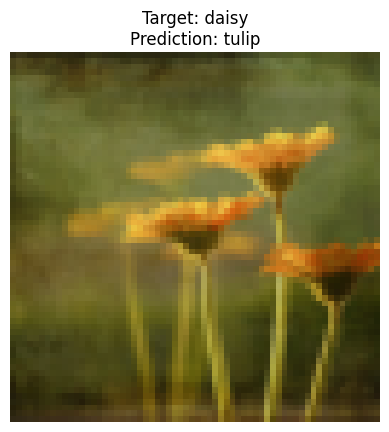

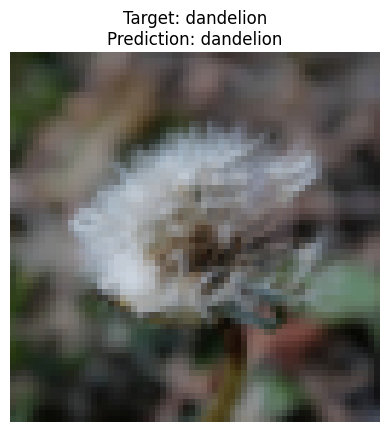

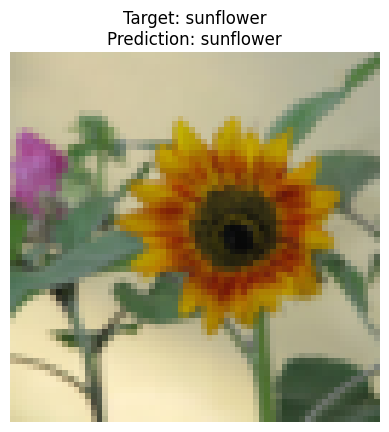

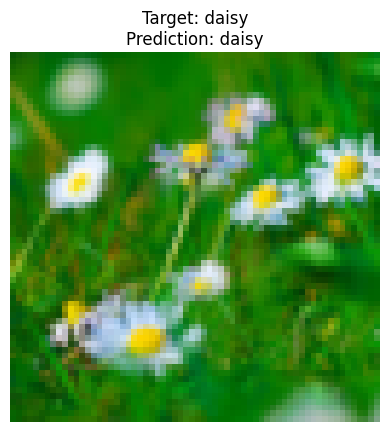

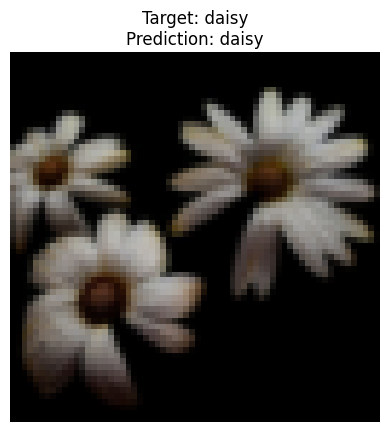

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def denormalize(image, means, stds):
    """Reverses the normalization applied to images."""
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return image * stds + means

def predict_image(img, model, device):
    """Predicts the class for a single image tensor."""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from the model
    yb = model(xb)
    # Pick index with the highest probability
    _, preds = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

def show_image_prediction(img, label, model, dataset, device):
    """Shows the image and the model's prediction."""
    # Denormalize the image
    denorm_img = denormalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # Convert to numpy array for imshow
    img_np = denorm_img.squeeze().detach().cpu().numpy()
    # Ensure the image has the correct shape (H x W x C) for matplotlib
    if img_np.ndim == 3:
        img_np = np.transpose(img_np, (1, 2, 0))
    img_np = np.clip(img_np, 0, 1)  # Clip the values to be between 0 and 1

    # Display the image
    plt.imshow(img_np)
    plt.axis('off')

    # Predict the class
    pred = predict_image(img, model, device)
    plt.title(f'Target: {dataset.classes[label]}\nPrediction: {pred}')
    plt.show()

# Testing the prediction on some images from the validation set
for i in range(5):
    img, label = valid_ds[i]
    show_image_prediction(img, label, model, dataset, device)


### In-Depth Evaluation of the Model

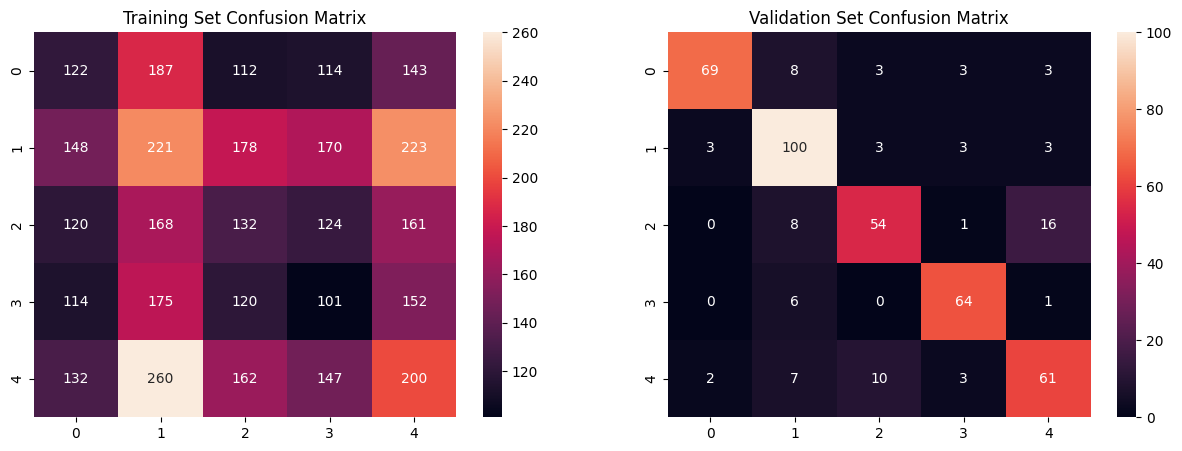

              precision    recall  f1-score   support

       daisy       0.93      0.80      0.86        86
   dandelion       0.78      0.89      0.83       112
        rose       0.77      0.68      0.72        79
   sunflower       0.86      0.90      0.88        71
       tulip       0.73      0.73      0.73        83

    accuracy                           0.81       431
   macro avg       0.81      0.80      0.81       431
weighted avg       0.81      0.81      0.81       431



In [ ]:

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Adjust the number of workers to the suggested maximum
num_workers = 2

# Modify the data loaders to use the recommended number of workers
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=num_workers, pin_memory=True)

def get_all_preds(model, loader, device):
    all_preds = torch.tensor([]).to(device)
    for batch in loader:
        images, labels = batch
        images = images.to(device)

        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

# Disable gradients for faster calculations
with torch.no_grad():
    train_preds = get_all_preds(model, train_dl, device)
    train_preds_classes = train_preds.argmax(dim=1)
    valid_preds = get_all_preds(model, valid_dl, device)
    valid_preds_classes = valid_preds.argmax(dim=1)

# Get the actual labels for the training and validation sets
train_labels = torch.cat([y for _, y in train_dl], dim=0).to(device)
valid_labels = torch.cat([y for _, y in valid_dl], dim=0).to(device)

# Move predictions and labels to CPU for sklearn operations
train_preds_classes = train_preds_classes.cpu()
valid_preds_classes = valid_preds_classes.cpu()
train_labels = train_labels.cpu()
valid_labels = valid_labels.cpu()

# Calculate the confusion matrices for the training and validation sets
train_confusion_matrix = confusion_matrix(train_labels, train_preds_classes)
valid_confusion_matrix = confusion_matrix(valid_labels, valid_preds_classes)

# Plot the confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(train_confusion_matrix, annot=True, ax=ax[0], fmt='g')
ax[0].set_title('Training Set Confusion Matrix')
sns.heatmap(valid_confusion_matrix, annot=True, ax=ax[1], fmt='g')
ax[1].set_title('Validation Set Confusion Matrix')
plt.show()

# Print classification report for the validation set
print(classification_report(valid_labels, valid_preds_classes, target_names=dataset.classes))


### Enhanced Training with Improvements and Visualization for ResNet50

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time
import copy

# Function to train the model and return the training history
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    early_stop_count = 0
    early_stop_patience = 3  # Number of epochs to wait for improvement before stopping

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloaders = train_dl
            else:
                model.eval()   # Set model to evaluate mode
                dataloaders = valid_dl

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders.dataset)
            epoch_acc = running_corrects.double() / len(dataloaders.dataset)

            history[phase + '_loss'].append(epoch_loss)
            history[phase + '_acc'].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stop_count = 0
                else:
                    early_stop_count += 1

                if early_stop_count >= early_stop_patience:
                    print('Early stopping triggered after {} epochs without improvement'.format(early_stop_patience))
                    break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Initialize the model for this run
model_ft = models.resnet50(pretrained=True)

# Freeze all the layers in the pre-trained model
for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(dataset.classes))

# Move the model to the GPU
model_ft = model_ft.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Only parameters of the final layer are being optimized as before
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs as before
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate the model with early stopping
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 1.1153 Acc: 0.5695
val Loss: 0.8852 Acc: 0.6682

Epoch 1/24
----------
train Loss: 0.7562 Acc: 0.7290
val Loss: 0.8157 Acc: 0.7169

Epoch 2/24
----------
train Loss: 0.6768 Acc: 0.7540
val Loss: 0.7785 Acc: 0.7401

Epoch 3/24
----------
train Loss: 0.6319 Acc: 0.7733
val Loss: 0.7823 Acc: 0.7355

Epoch 4/24
----------
train Loss: 0.5999 Acc: 0.7880
val Loss: 0.7677 Acc: 0.7448

Epoch 5/24
----------
train Loss: 0.5862 Acc: 0.7885
val Loss: 0.8704 Acc: 0.6984

Epoch 6/24
----------
train Loss: 0.5592 Acc: 0.8021
val Loss: 0.7538 Acc: 0.7309

Epoch 7/24
----------
train Loss: 0.5301 Acc: 0.8155
val Loss: 0.7576 Acc: 0.7448
Early stopping triggered after 3 epochs without improvement

Epoch 8/24
----------
train Loss: 0.5193 Acc: 0.8230
val Loss: 0.7456 Acc: 0.7401
Early stopping triggered after 3 epochs without improvement

Epoch 9/24
----------
train Loss: 0.5109 Acc: 0.8268
val Loss: 0.7642 Acc: 0.7471

Epoch 10/24
----------
train Loss: 0.5140 Acc: 0.8

### In-Depth Evaluation of the Model

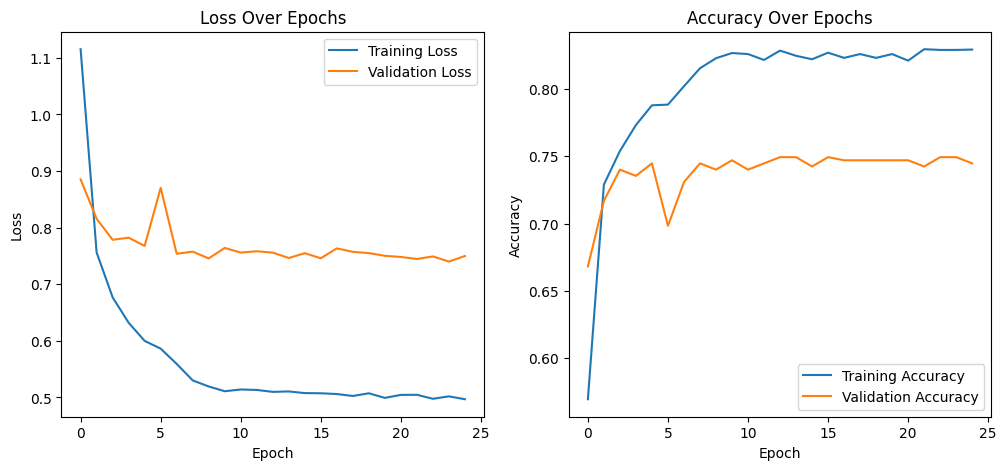

In [ ]:
def plot_training_history(history):
    # Extract the data from history dictionary
    train_losses = history['train_loss']
    val_losses = history['val_loss']
    train_accs = [x.cpu().numpy() for x in history['train_acc']]  # Convert tensors to numpy arrays
    val_accs = [x.cpu().numpy() for x in history['val_acc']]  # Convert tensors to numpy arrays

    # Plotting training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Call the function with your history data
plot_training_history(history)


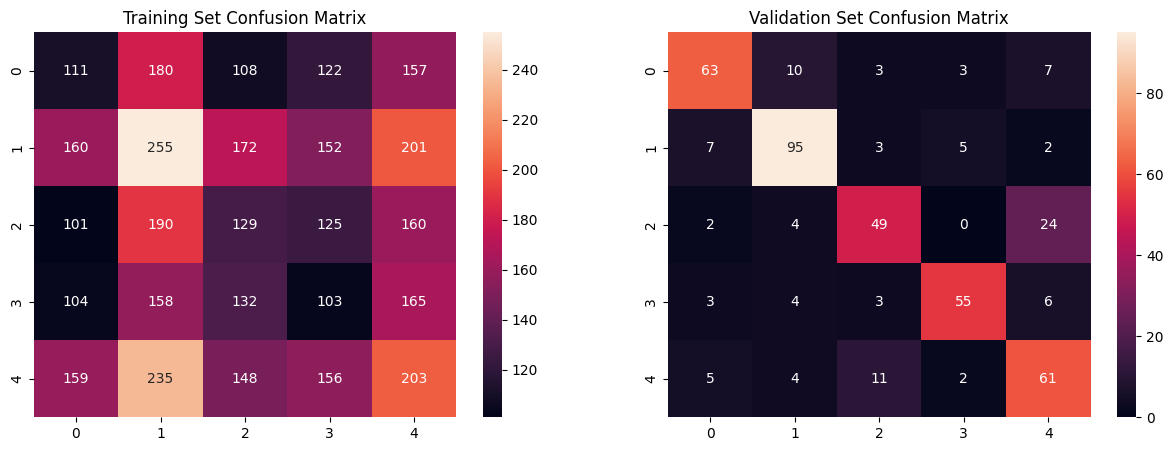

Classification Report for Validation Set:

              precision    recall  f1-score   support

       daisy       0.79      0.73      0.76        86
   dandelion       0.81      0.85      0.83       112
        rose       0.71      0.62      0.66        79
   sunflower       0.85      0.77      0.81        71
       tulip       0.61      0.73      0.67        83

    accuracy                           0.75       431
   macro avg       0.75      0.74      0.75       431
weighted avg       0.76      0.75      0.75       431



In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def get_all_preds(model, loader, device):
    all_preds = torch.tensor([]).to(device)
    for batch in loader:
        images, labels = batch
        images = images.to(device)
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft.to(device)

# Disable gradients for faster calculations
with torch.no_grad():
    train_preds = get_all_preds(model_ft, train_dl, device)
    train_preds_classes = train_preds.argmax(dim=1)
    valid_preds = get_all_preds(model_ft, valid_dl, device)
    valid_preds_classes = valid_preds.argmax(dim=1)

# Get actual labels
train_labels = torch.cat([y for _, y in train_dl], dim=0).to(device)
valid_labels = torch.cat([y for _, y in valid_dl], dim=0).to(device)

# Move predictions and labels to CPU
train_preds_classes = train_preds_classes.cpu()
valid_preds_classes = valid_preds_classes.cpu()
train_labels = train_labels.cpu()
valid_labels = valid_labels.cpu()

# Calculate confusion matrices
train_confusion_matrix = confusion_matrix(train_labels, train_preds_classes)
valid_confusion_matrix = confusion_matrix(valid_labels, valid_preds_classes)

# Plot the confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(train_confusion_matrix, annot=True, ax=ax[0], fmt='g')
ax[0].set_title('Training Set Confusion Matrix')
sns.heatmap(valid_confusion_matrix, annot=True, ax=ax[1], fmt='g')
ax[1].set_title('Validation Set Confusion Matrix')
plt.show()

# Print classification report for validation set
print("Classification Report for Validation Set:\n")
print(classification_report(valid_labels, valid_preds_classes, target_names=dataset.classes))


#### **Precision:**
Precision measures the accuracy of positive predictions for each class.
ResNet9 has higher precision for 'daisy' and 'sunflower' classes, while ResNet50 has higher precision for 'dandelion'.
For 'rose' and 'tulip', the precision is slightly lower for ResNet50 compared to ResNet9.
#### **Recall:**
Recall indicates the ability of the model to find all the relevant instances of a class.
ResNet9 outperforms ResNet50 in recall for 'daisy', 'sunflower', and 'tulip'.
ResNet50 shows a slightly higher recall for 'dandelion', but it falls behind in the 'rose' category.
#### **F1-Score:**
The f1-score provides a balance between precision and recall, offering a single measure of performance.
ResNet9 exhibits higher f1-scores for all classes except 'dandelion', where the models perform equally.
#### **Support:**
The support metric shows the number of true instances for each class.
Both models were evaluated on the same support, allowing for a direct comparison of the metrics.
#### **Overall Accuracy:**
The overall accuracy reflects the proportion of the total number of predictions that were correct.
ResNet9 has a higher overall accuracy of 0.81 compared to 0.75 for ResNet50.
#### **Conclusion:**
Based on the comparison, ResNet9 appears to be the better model for this specific flower recognition task. It not only has a higher overall accuracy but also demonstrates superior performance across most individual classes when considering both precision and recall. The higher f1-scores for ResNet9 indicate a better balance between precision and recall, suggesting it is more reliable for consistent classification across the different flower types. Furthermore, the higher precision of ResNet9 for 'daisy' and 'sunflower' is significant since these classes are likely important for the task at hand.